# Two-temperature model

This Julia code solves the two-temperature model for the electron and lattice subsystems.

In [1]:
using Plots, LaTeXStrings, QuadGK, Unitful, DataFrames

The two-temperature model is a system of two coupled partial differential equations for the electron and lattice temperatures $T_e$ and $T_p$:

$$
\begin{align}
    C_e(T_e)\frac{\mathrm{d}T_e}{\mathrm{d}t} & = -G(T_e - T_p) + S(t) \\
    C_l\frac{\mathrm{d}T_p}{\mathrm{d}t} & = G(T_e - T_p) - \frac{T_p - T_0}{\tau_\mathrm{D}}
\end{align}
$$

For the source term (laser pulse power), we use the following expression:

$$
P(t) = \frac{P_\mathrm{avg}}{f_\mathrm{rep}\tau_p}\frac{(1-R)(1-e^{-\alpha d})}{A d} \exp\left(-4\ln(2)\frac{t^2}{\tau_p^2}\right) 
$$

The pulse duration is $\tau_p = 100\,\mathrm{fs}$, the average power $P_\mathrm{avg} = 2\,\mathrm{mW}$, and the laser repetition rate $f_\mathrm{rep} = 1\,\mathrm{kHz}$. The reflectance is [$R = 0.2$](https://doi.org/10.1002/aenm.201201116), and the film thickness $d = 36\,\mathrm{nm}$. The absorption coefficient [$\alpha = 1.7\times10^5\,\mathrm{cm^{-1}}$](https://doi.org/10.1002/aenm.201201116). The spot area is $A = 16.6\,\mathrm{mm^2}$ (based on a beam diameter of 4.6 mm).

The energy-transfer coefficient $G$ was shown to be related to the electron-phonon coupling constant by [Allen (PRL, 1987)](https://doi.org/10.1103/PhysRevLett.59.1460).

In [2]:
P_av = 2.0u"mW"
f_rep = 1.0u"kHz"
τ = 110.0u"fs" * 1.5
w = 2.3u"mm"
d = 21.7u"nm" # Film thickness
lda = 800u"nm" # Wavelength
F_peak = P_av / (f_rep * pi * w^2 / 2) # Peak fluence
ns = 1.4305  # Index of refraction, CaF2

function absorptance(k, n, κ, d)
    x = 2 * k * d * κ * n
    return 4 * x / (1 + ns + x)^2
end

k = 2 * pi / 640u"nm"
P_pulse = F_peak * absorptance(k, 1.96, 0.96, d) / (d * τ) |> u"J/ps/m^3"

2.0634252171424605e7 J m⁻³ ps⁻¹

In [3]:
function gaussian(t, tau)
    sig = tau / (2 * sqrt(2 * log(2)))
    return 1 / (sig * sqrt(2 * pi)) * exp(-t^2 / (2 * sig^2))
end

function pulse(t)
    return ustrip(P_pulse |> u"J/ps/m^3") * gaussian(t, ustrip(τ |> u"ps"))
end

pulse (generic function with 1 method)

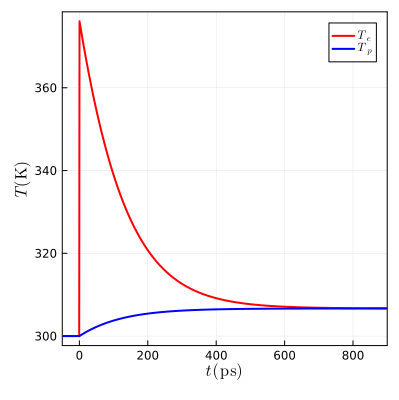

In [6]:
using DifferentialEquations

function twotemp!(dT, T, p, t)
    G, C_e, C_l = p[1], p[2] * T[1], p[3]
    dT[1] = (1 / C_e) * (pulse(t) - G * (T[1] - T[2]))
    dT[2] = (1 / C_l) * (G * (T[1] - T[2]))
end

T0 = [300.0; 300.0] # [K]
tspan = (-50.0, 900.0) # [ps]

# SrRuO3
G = 2e15u"W/K/m^3" |> u"Pa/ps/K"
a = 800u"Pa/K^2"
C_l = 2.85u"J/K/cm^3" |> u"Pa/K"

prob = ODEProblem(twotemp!, T0, tspan, ustrip.([G, a, C_l]))
sol = solve(prob,
    alg=Rodas5P(),
    tstops=range(-1.0, 1.0, 20),
    save_everystep=true,
    maxiters=1e7)

plot(sol, color="red", label=L"$T_e$", xlabel=L"$t\,(\mathrm{ps})$", layout=(1, 1), idxs=1, lw=2)
plot!(sol, color="blue", label=L"$T_p$", subplot=1, idxs=2, lw=2)
plot!(framestyle=:box, size=(400, 400), xlabel=L"$t\,(\mathrm{ps})$", ylabel=L"$T\,(\mathrm{K})$", legend=:topright)

In [102]:
# Store solution on time grid

using DataFrames, CSV

t = range(-10, 1000, length=10000)
data = DataFrame(sol(t), [:t, :T_e, :T_p])
CSV.write("./processed_data/2T_solution.csv", data)

"./processed_data/2T_solution.csv"

In [121]:
import PhysicalConstants.CODATA2018: ħ, m_e

# Electronic bulk modulus, SrRuO3

vF = sqrt(0.8e14u"cm^2/s^2")
n = 2e22u"1/cm^3"
m_e_star = 3.9 * m_e

B_e = (1 / 3) * n * m_e_star * vF^2 |> u"GPa"

0.18947518099119992 GPa

In [120]:
# Electronic bulk modulus, Au 

vF = 1.4e6u"m/s" |> u"nm/ps"
n = 6e22u"1/cm^3"
m_e_star = m_e

B_e = (1 / 3) * n * m_e_star * vF^2 |> u"GPa"

35.70878410988 GPa